In [1]:
%matplotlib inline
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as signal
import seaborn as sns
import os.path as op
# import skfda
# from sklearn.decomposition import NMF
# import tslearn

In [37]:
def make_emg_obj(fname):
  dat = sp.io.loadmat(fname)
  dat_seq = dat["data"]
  st = dat["datastart"]
  ed = dat["dataend"]
  labels = dat["titles"]
  dat_emg = pd.DataFrame()
  for s, e, la in zip(st, ed, labels):
    if s == -1:
      continue
    else:
      la = la.replace(" ", "")
      dat_emg[la] = dat_seq[0][int(s-1):int(e-1)]
  if dat_emg.shape[1] == 16:
    labels = ["Rt_TA", "Rt_SOL", "Rt_GM", "Rt_GL", "Rt_VM", "Rt_VL", "Rt_Ham", "Lt_TA", 
              "Lt_SOL", "Lt_GM", "Lt_GL", "Lt_VM", "Lt_VL", "Lt_Ham", "Rt_foot", "Lt_foot"]
    dat_emg.columns = labels
    val = dat_emg["Rt_foot"].values
    val = val - min(val)
    val[val < np.max(val)/3] = 0
    events = [1 if val[j-1] == 0 and val[j]>0 else 0 for j in range(len(val))]
    dat_emg_foot = dat_emg.iloc[:,:14]
    dat_emg_foot["Foot"] = events
  else:
    val = dat_emg["Foot"].values
    val = val - min(val)
    val[val < np.max(val)/3] = 0
    events = [1 if val[j-1] == 0 and val[j]>0 else 0 for j in range(len(val))]
    dat_emg_foot = dat_emg
    dat_emg_foot["Foot"] = events
  return dat_emg_foot



# set montage
def make_montage(fname):
  montage = mne.channels.read_custom_montage(fname)
  _montage = montage.get_positions()["ch_pos"]
  
  for mtg in _montage:
    _montage[mtg] += (0, 0.01, 0.04)
  
  return mne.channels.make_dig_montage(_montage)



def read_eeg(fname, montage):
  raw = mne.io.read_raw_edf(fname)
  ch_names = raw.info["ch_names"]
  new_names = [ch_name.replace("EEG ","").replace("-Ref","") for ch_name in ch_names]
  ch_names_dic = dict(zip(ch_names, new_names))
  mne.rename_channels(raw.info, ch_names_dic)
  retype = {"EOG":"eog"}
  raw.set_channel_types(retype)
  raw.set_montage(montage)
  return raw.set_montage(montage)



def add_event(eeg, emg):
  length = min(eeg.last_samp, len(emg)-1)
  foot = emg.loc[:length, ["Foot"]].values.T
  stim = mne.create_info(ch_names = ["Heel"], sfreq=1000, ch_types = "stim")
  event = mne.io.RawArray(data = foot, info = stim)
  eeg.crop(0, length/1000)
  eeg.load_data()
  return eeg.add_channels([event]), emg.iloc[:(length+1),:]



def prep_eeg(eeg, l_freq, h_freq, method, bad_channels):
  eeg.load_data()  # データを読み込む
  eeg.filter(l_freq=l_freq, h_freq = h_freq, method = method)
  eeg.info["bads"].extend(bad_channels)  # bad channels
  return eeg.set_eeg_reference(ref_channels='average', projection=True)



def prep_emg(emg, h_freq, l_freq, Wn, btype):
  emg_raw = emg.iloc[:,:-1]
  emg_event = emg["Foot"]
  event_idx = emg_event[emg_event==1].index
  emg_raw = emg_raw - emg_raw.mean()
  b, a = sp.signal.butter(Wn, [h_freq,l_freq], btype=btype)
  for ch in emg_raw.columns:
    emg_raw[ch] = sp.signal.filtfilt(b, a, emg_raw[ch])
  return  emg_raw.abs(), event_idx



# エポッキング
def make_epochs(eeg, emg, tmin, tmax):
  event = mne.find_events(eeg)
  event_dict = {"HC":1}
  eeg_epochs = mne.Epochs(eeg, event, event_id = event_dict, tmin = tmin, tmax = tmax, preload = True)
  # eeg_epochs.drop_log
  emg_drop_log = []
  # EMGエポッキング
  for i, idx in enumerate(event_idx):
    if i == len(event_idx):
      break
    elif len(emg_raw.iloc[int(idx+tmin*1000):int(idx+tmax*1000),:]) < (tmax -tmin)*1000:
      emg_drop_log.append(f"the {i+1}th epoch has too short! exclude this epoch. {len(emg_raw.iloc[int(idx+tmin*1000):int(idx+tmax*1000),:])}")
      continue
    elif i == 0:
      emg_epochs = emg_raw.iloc[int(idx+tmin*1000):int(idx+tmax*1000),:].values[np.newaxis]
    else:
      emg_epochs = np.append(emg_epochs, emg_raw.iloc[int(idx+tmin*1000):int(idx+tmax*1000),:].values[np.newaxis], axis=0)
  return eeg_epochs, emg_epochs, eeg_epochs.drop_log, emg_drop_log



def make_epochs_list(eeg, emg, event_idx):
  emg_epochs = []
  for ev in range(len(event_idx)):
    if ev+1 == len(event_idx):
      break
    else:
      emg_epochs.append(emg_raw.iloc[event_idx[ev]:event_idx[ev+1]])
  eeg_raw = pd.DataFrame(eeg.get_data().T, columns= eeg.info["ch_names"]).iloc[:,:64]
  eeg_epochs = []
  for ev in range(len(event_idx)):
      if ev+1 == len(event_idx):
          break
      else:
          eeg_epochs.append(eeg_raw.iloc[event_idx[ev]:event_idx[ev+1]])
  return eeg_epochs, emg_epochs


# LLN
def approx(x, method, n):
  import numpy as np
  from scipy.interpolate import interp1d
  y = np.arange(0, len(x), 1)
  f = interp1d(y, x, kind = method)
  y_resample = np.linspace(0, len(x)-1, n)
  return f(y_resample)


def lln_list(epochs_list, n):
  #n = n
  method = "linear"
  epochs = np.zeros([len(epochs_list), n, epochs_list[0].shape[1]])
  for i, epoch in enumerate(epochs_list):
    for j, mus in enumerate(epoch):
      if i == len(epochs_list):
        break
      epochs[i,:,j] = approx(epoch[mus], method, n)
  return epochs


In [3]:
# director設定
import os
print(os.getcwd())
os.chdir("/Users/koji/Desktop/research/")
print(os.getcwd())

/Users/koji/Desktop/research/script
/Users/koji/Desktop/research


# filepathの指定

In [4]:
from glob import glob
emg_path = glob("./data/Data_original/Young/EMG/Nagashima*.mat")
emg_path.sort()
del emg_path[0]
print(emg_path)
eeg_path = glob("./data/Data_original/Young/EEG/Nagashima*.edf")
eeg_path.sort()
print(eeg_path)

['./data/Data_original/Young/EMG/Nagashima_RAS100.mat', './data/Data_original/Young/EMG/Nagashima_RAS110.mat', './data/Data_original/Young/EMG/Nagashima_RAS90.mat', './data/Data_original/Young/EMG/Nagashima_noRAS1.mat', './data/Data_original/Young/EMG/Nagashima_noRAS2.mat']
['./data/Data_original/Young/EEG/Nagashima_RAS100_Segment_0.edf', './data/Data_original/Young/EEG/Nagashima_RAS110_Segment_0.edf', './data/Data_original/Young/EEG/Nagashima_RAS90_Segment_0.edf', './data/Data_original/Young/EEG/Nagashima_noRAS1_Segment_0.edf', './data/Data_original/Young/EEG/Nagashima_noRAS2_Segment_0.edf']


# データの読み込み
no RAS1がパスの4番目にあるので、これを読み込み、可視化する。
make_emg_obj関数はmatファイルのパスを指定すると、自動的にDataFrame型に変換し、HCイベントの瞬間を1とするようなスクリプトになっている。

<AxesSubplot:>

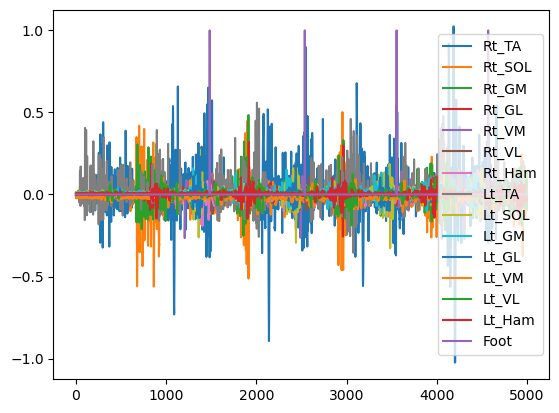

In [38]:
emg = make_emg_obj(emg_path[3])
emg.iloc[:5000,:].plot()

In [6]:
montage = make_montage("./data/elect_loc64_2.elc")
eeg = read_eeg(fname = eeg_path[3], montage = montage)
print(emg.shape)
print(eeg.get_data().T.shape)

Extracting EDF parameters from /Users/koji/Desktop/research/data/Data_original/Young/EEG/Nagashima_noRAS1_Segment_0.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(141899, 15)
(142000, 64)


In [7]:
eeg.plot(duration=3)

Using qt as 2D backend.
Using pyopengl with version 3.1.6


プロットを確認すると、EMGは1.5秒から定常になっているのに対して、EEGはおよそ10秒間は振幅が異常に大きいものが続き、その後安定する。

EEGの波形を最後の3秒ほど確認すると、シグナルが完全になくなっていることがわかる。これは、おそらく電源を止めた後のラグがあるものと考えられる。
初めのタイミングで揃えて、後ろが揃うように余分な時間を除外する。

In [39]:
eeg.crop(0,120)
emg = emg.iloc[:120000,:]

# エポックの長さの比較検討

In [27]:
# event_idx = emg["Foot"][emg["Foot"]==1].index
for i in range(len(event_idx)):
    if i == len(event_idx)-1:
        break
    print(event_idx[i+1]-event_idx[i])

1054
1018
1015
1010
1007
1039
1007
1014
1028
1034


# エポックごとのばらつきを可視化

<AxesSubplot:>

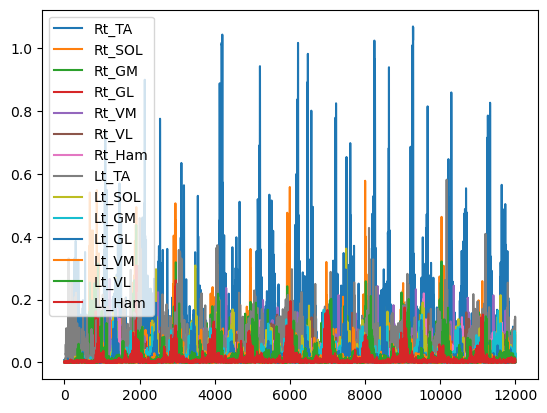

In [40]:
# エポックに区切る前にEMG前処理をしておく
h_freq = 5 / (1000/2)
l_freq = 250 / (1000/2)
Wn = 4
btype = "bandpass"
emg, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)
# emg.plot()

In [51]:
emg_prep = emg.copy()
low_pass = 10 / (1000/2)
b2, a2 = sp.signal.butter(4, low_pass, btype = 'lowpass')
for ch in emg_prep.columns:
  emg_prep[ch] = sp.signal.filtfilt(b2, a2, emg_prep[ch])
  emg_prep[ch] = np.abs(sp.signal.hilbert(emg_prep[ch]))
emg = emg_prep.copy()

In [52]:
epochs = []
for i in range(len(event_idx)):
    if i == len(event_idx)-1:
        break
    epochs.append(emg.iloc[event_idx[i]:event_idx[i+1],:])

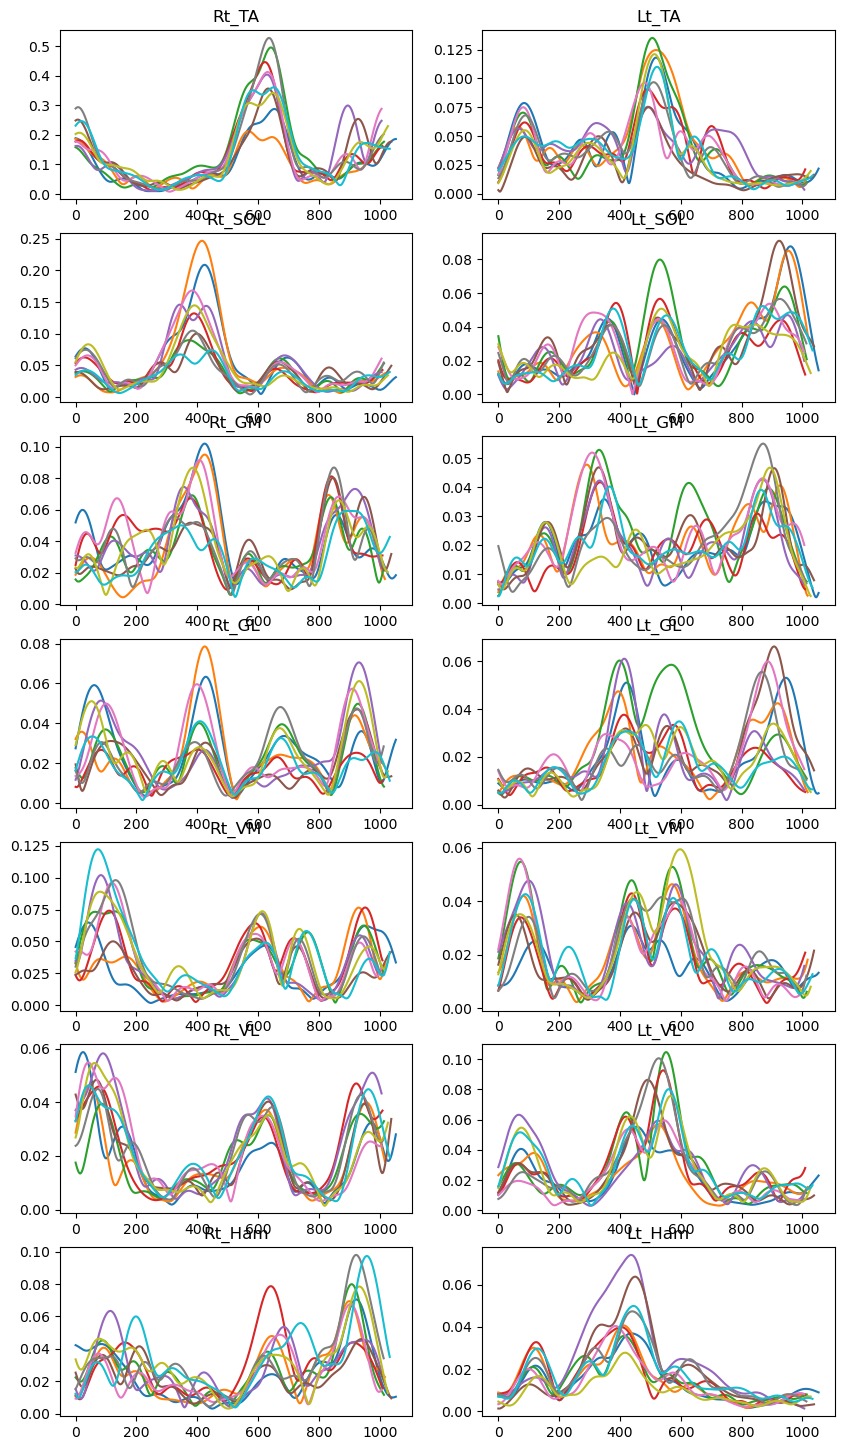

In [54]:
fig, ax = plt.subplots(7,2,figsize=(10,18))
for epoch in epochs:
    for i, (a,mus) in enumerate(zip(ax.flatten(order="F"), epoch)):
        a.plot(np.arange(epoch.shape[0]), epoch[mus])
        a.set_title(mus)

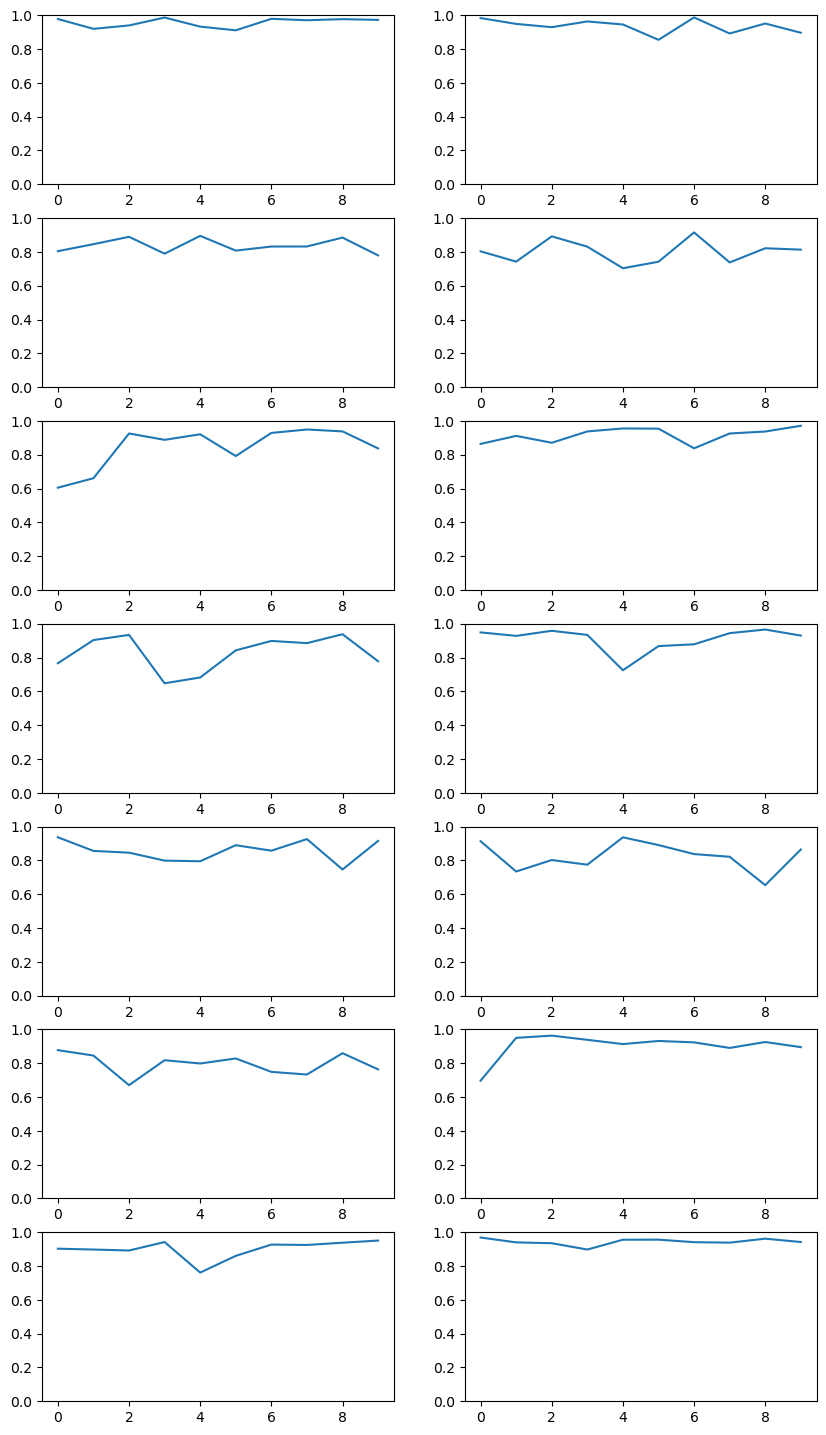

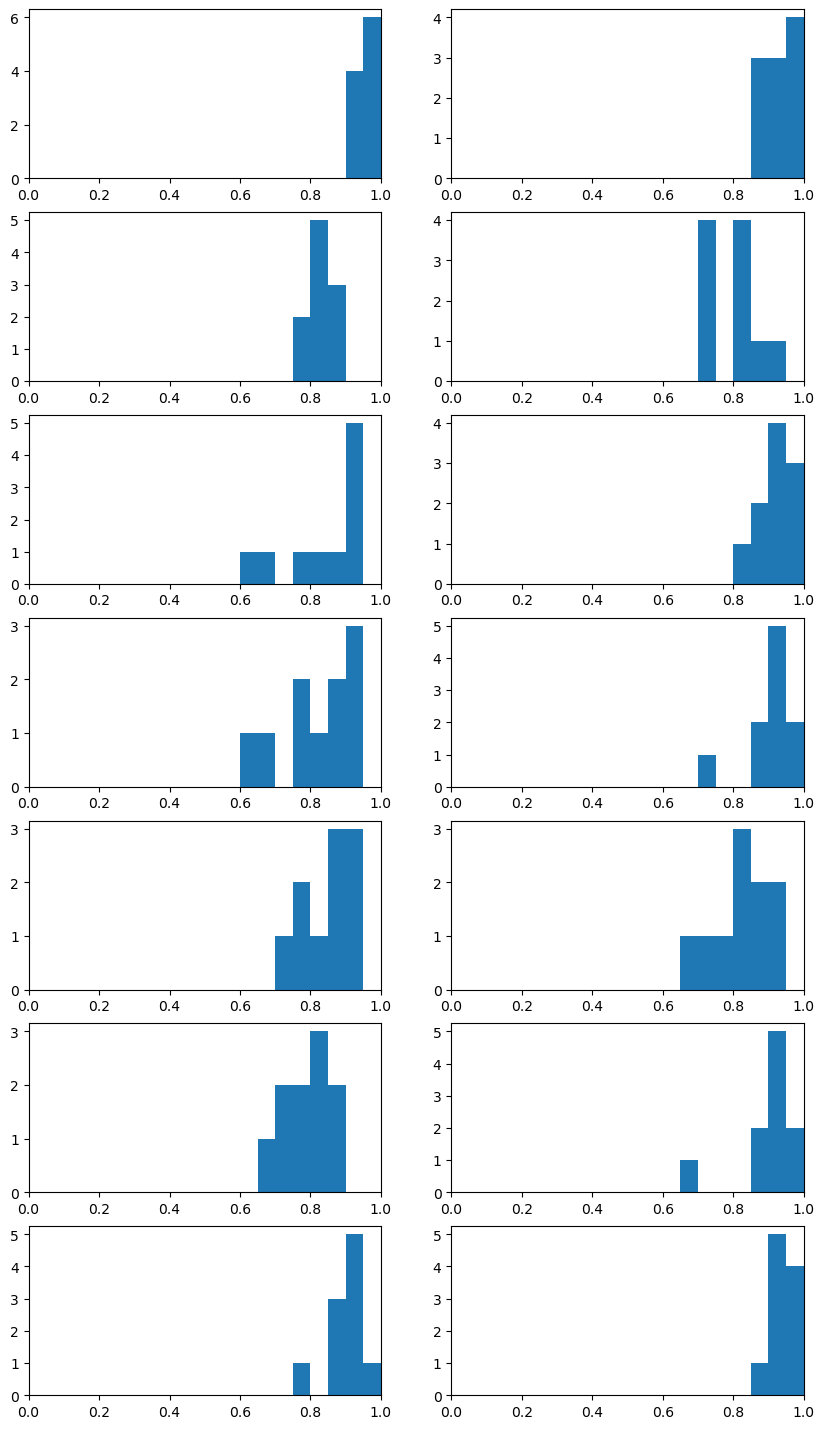

In [58]:
n = 1000
emg_epochs = lln_list(epochs, n)
emg_mn = emg_epochs.mean(axis=0)
t = np.linspace(0,100,n)


res_mus = []
for l1, mus in zip(emg_mn.T, emg_epochs.T):
    l1 = pd.Series(l1)
    res = []
    for ep in mus.T:
        l2 = pd.Series(ep)
        cor = l1.corr(l2)
        res.append(cor)
    res_mus.append(res)

fig, ax = plt.subplots(7,2, figsize=(10,18))
ax = ax.flatten()
for i, res in enumerate(res_mus):
    ax[i].plot(np.arange(len(res)), res)
    # ax[i].set_title(f"{mus_idx[i]} : {np.round(np.mean(res), 4)}")
    ax[i].set_ylim(0,1)
# plt.suptitle(f"{name}: {ras}")
# plt.savefig(f"./misc/plot/1027/{name}_{ras}_cor.png", dpi=128)

fig, ax = plt.subplots(7,2, figsize=(10,18))
ax = ax.flatten()
for i in range(len(res_mus)):
    ax[i].hist(res_mus[i], bins=20,range=(0,1))
    ax[i].set_xlim(0, 1)
    # ax[i].set_title(f"{mus_idx[i]} : {np.round(np.mean(res), 4)}")
# plt.suptitle(f"{name}: {ras}")
# plt.savefig(f"./misc/plot/1027/{name}_{ras}_cor_bar.png", dpi=128)


# まとめて解析をする
周期ごとのケイデンスのばらつき、周期ごとの波形、波形のばらつきを相関係数で評価、ヒストグラムまで

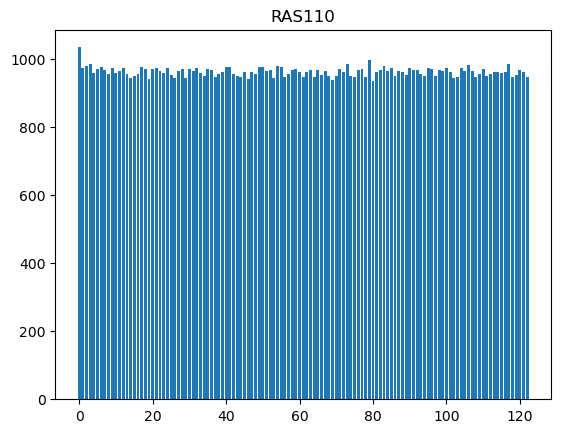

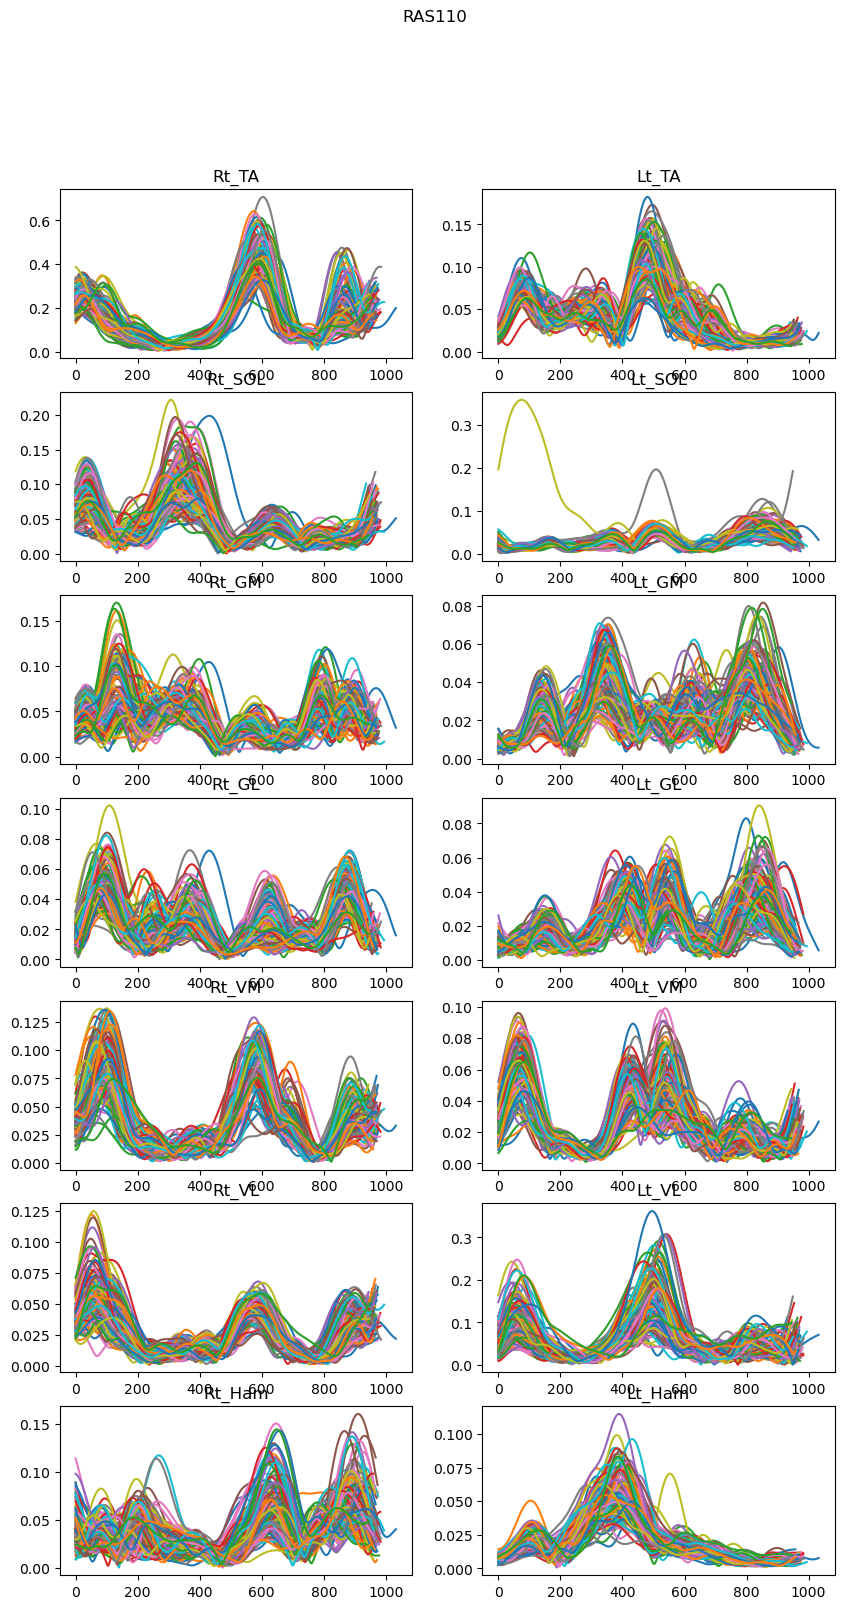

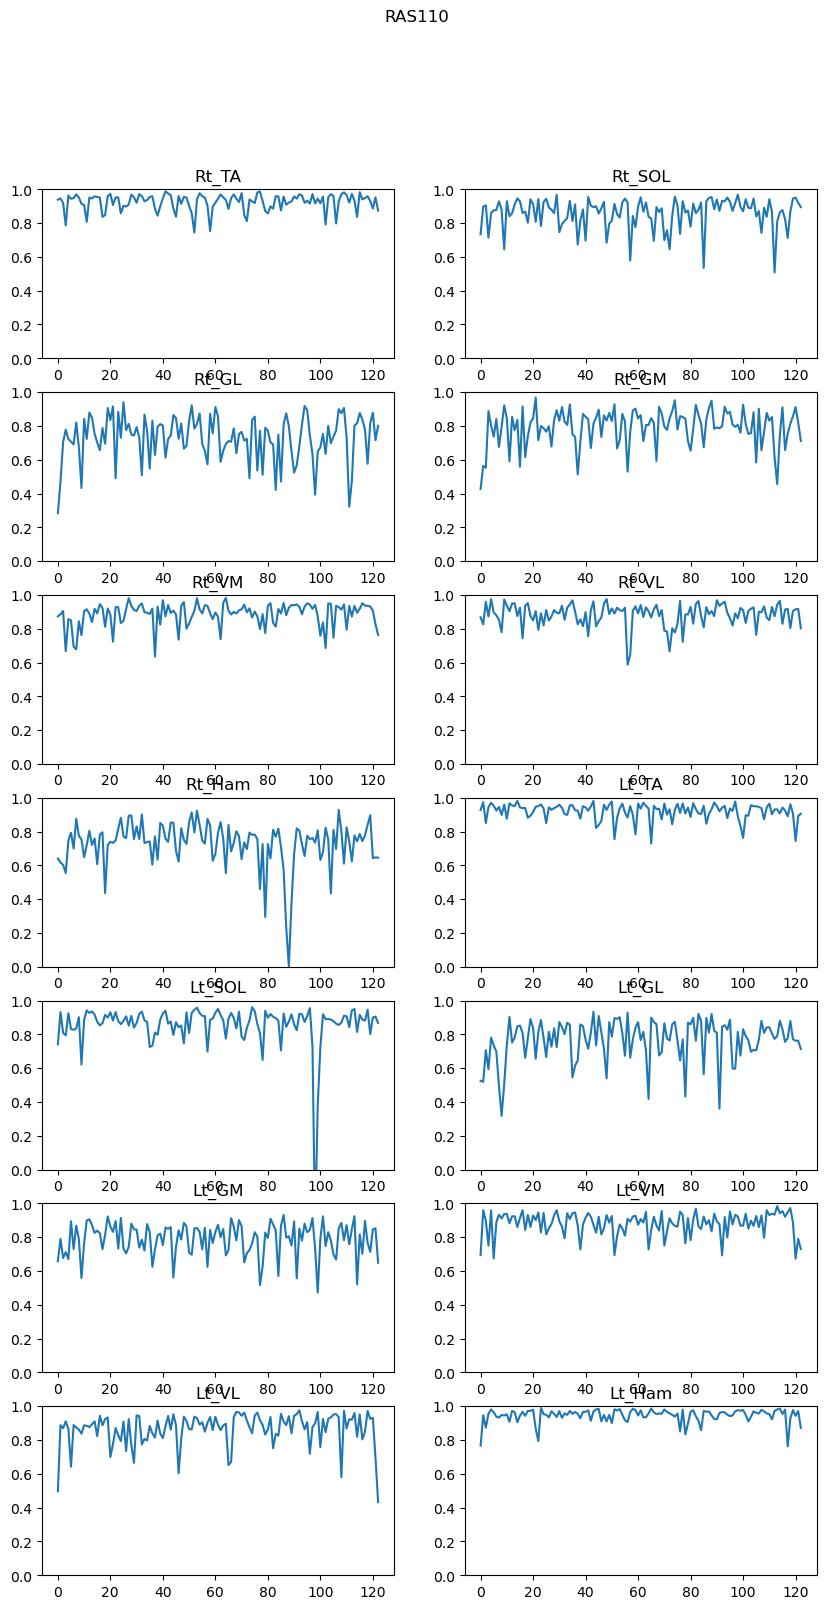

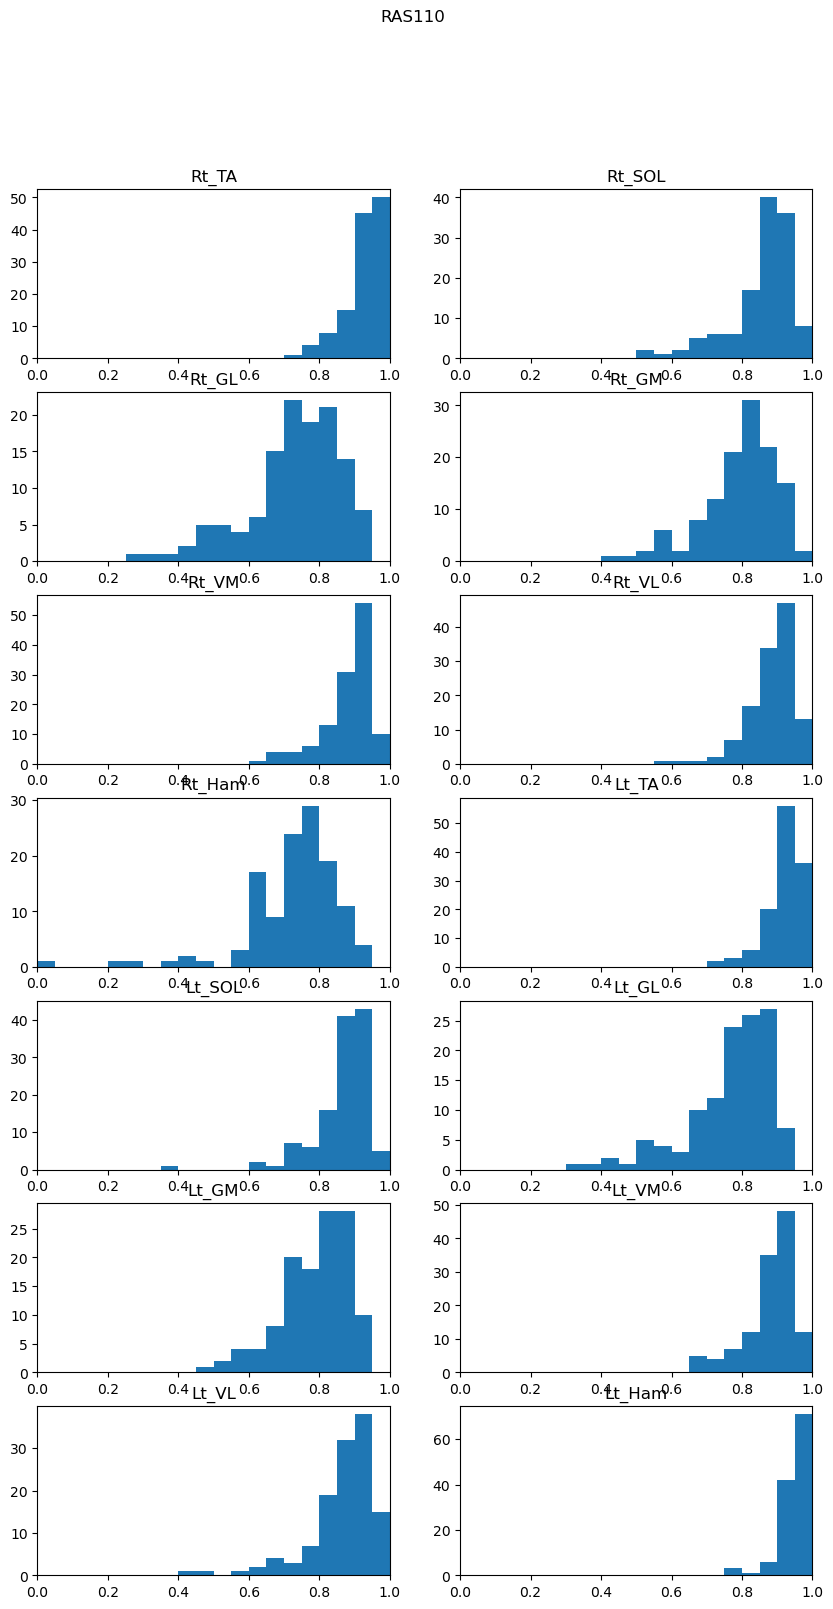

In [74]:
emg = make_emg_obj(emg_path[1])  # file_path
title = "RAS110"  # 条件

labels = ["Rt_TA", "Rt_SOL", "Rt_GL", "Rt_GM", "Rt_VM", "Rt_VL", "Rt_Ham", "Lt_TA", 
              "Lt_SOL", "Lt_GL", "Lt_GM", "Lt_VM", "Lt_VL", "Lt_Ham"]
emg = emg.iloc[:120000,:]

h_freq = 5 / (1000/2)
l_freq = 250 / (1000/2)
Wn = 4
btype = "bandpass"
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)
low_pass = 10 / (1000/2)
b2, a2 = sp.signal.butter(4, low_pass, btype = 'lowpass')
for ch in emg_prep.columns:
  emg_prep[ch] = sp.signal.filtfilt(b2, a2, emg_prep[ch])
  emg_prep[ch] = np.abs(sp.signal.hilbert(emg_prep[ch]))
# emg = emg_prep.copy()

# 周期の長さの確認
res = []
for i in range(len(event_idx)):
    if i == len(event_idx)-1:
        break
    res.append(event_idx[i+1]-event_idx[i])
fig, ax = plt.subplots()
plt.bar(range(len(res)),res)
plt.title(title)
plt.savefig(f"./misc/plot/jissen/{title}_length.png")

epochs = []
for i in range(len(event_idx)):
    if i == len(event_idx)-1:
        break
    epochs.append(emg_prep.iloc[event_idx[i]:event_idx[i+1],:])

fig, ax = plt.subplots(7,2,figsize=(10,18))
for epoch in epochs:
    for i, (a,mus) in enumerate(zip(ax.flatten(order="F"), epoch)):
        a.plot(np.arange(epoch.shape[0]), epoch[mus])
        a.set_title(mus)
plt.suptitle(title)
plt.savefig(f"./misc/plot/jissen/{title}_emg.png")

n = 1000
emg_epochs = lln_list(epochs, n)
emg_mn = emg_epochs.mean(axis=0)
t = np.linspace(0,100,n)


res_mus = []
for l1, mus in zip(emg_mn.T, emg_epochs.T):
    l1 = pd.Series(l1)
    res = []
    for ep in mus.T:
        l2 = pd.Series(ep)
        cor = l1.corr(l2)
        res.append(cor)
    res_mus.append(res)


fig, ax = plt.subplots(7,2, figsize=(10,18))
ax = ax.flatten()
for i, res in enumerate(res_mus):
    ax[i].plot(np.arange(len(res)), res)
    ax[i].set_ylim(0,1)
    ax[i].set_title(labels[i])
plt.suptitle(title)
plt.savefig(f"./misc/plot/jissen/{title}_corr.png")

fig, ax = plt.subplots(7,2, figsize=(10,18))
ax = ax.flatten()
for i in range(len(res_mus)):
    ax[i].hist(res_mus[i], bins=20,range=(0,1))
    ax[i].set_xlim(0, 1)
    ax[i].set_title(labels[i])
plt.suptitle(title)
plt.savefig(f"./misc/plot/jissen/{title}_corr_hist.png")

In [79]:
big_res = []
emg = make_emg_obj(emg_path[3])  # file_path
title = "noRAS"  # 条件
h_freq = 5 / (1000/2)
l_freq = 250 / (1000/2)
Wn = 4
btype = "bandpass"
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)

res = []
for i in range(len(event_idx)):
    if i == len(event_idx)-1:
        break
    res.append(event_idx[i+1]-event_idx[i])
big_res.append(res)

emg = make_emg_obj(emg_path[2])  # file_path
title = "RAS90"  # 条件
h_freq = 5 / (1000/2)
l_freq = 250 / (1000/2)
Wn = 4
btype = "bandpass"
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)
res = []
for i in range(len(event_idx)):
    if i == len(event_idx)-1:
        break
    res.append(event_idx[i+1]-event_idx[i])
big_res.append(res)

emg = make_emg_obj(emg_path[0])  # file_path
title = "RAS100"  # 条件
h_freq = 5 / (1000/2)
l_freq = 250 / (1000/2)
Wn = 4
btype = "bandpass"
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)
res = []
for i in range(len(event_idx)):
    if i == len(event_idx)-1:
        break
    res.append(event_idx[i+1]-event_idx[i])
big_res.append(res)

emg = make_emg_obj(emg_path[1])  # file_path
title = "RAS110"  # 条件
h_freq = 5 / (1000/2)
l_freq = 250 / (1000/2)
Wn = 4
btype = "bandpass"
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)
res = []
for i in range(len(event_idx)):
    if i == len(event_idx)-1:
        break
    res.append(event_idx[i+1]-event_idx[i])
big_res.append(res)


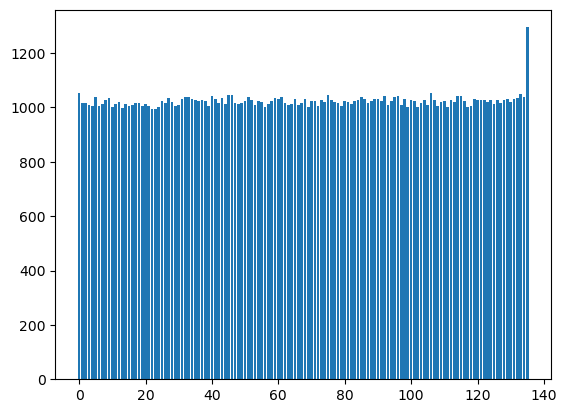

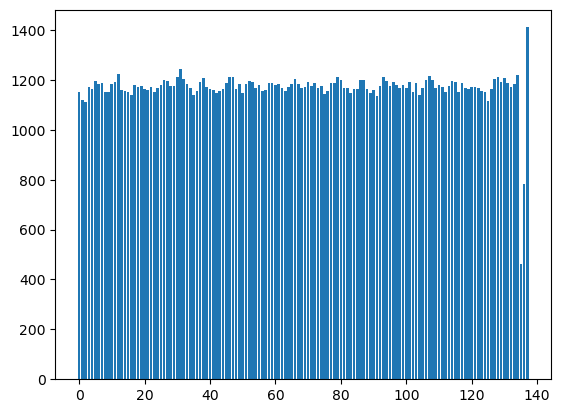

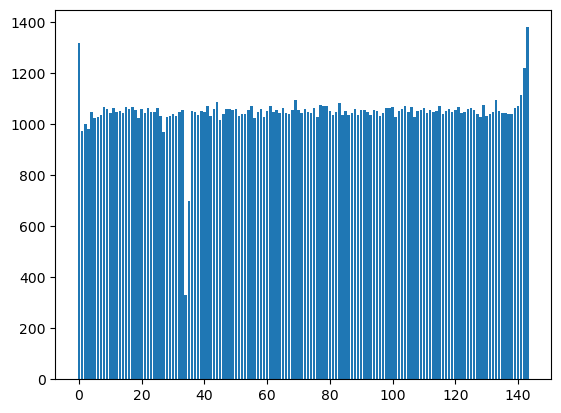

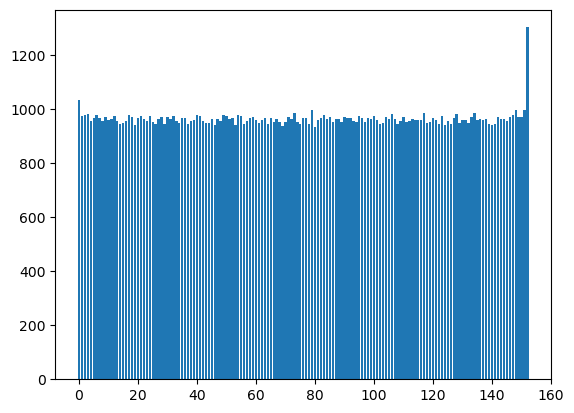

In [80]:
for res in big_res:
    fig, ax = plt.subplots()
    ax.bar(range(len(res)),res)

## boxplot

Text(0, 0.5, 'time[s]')

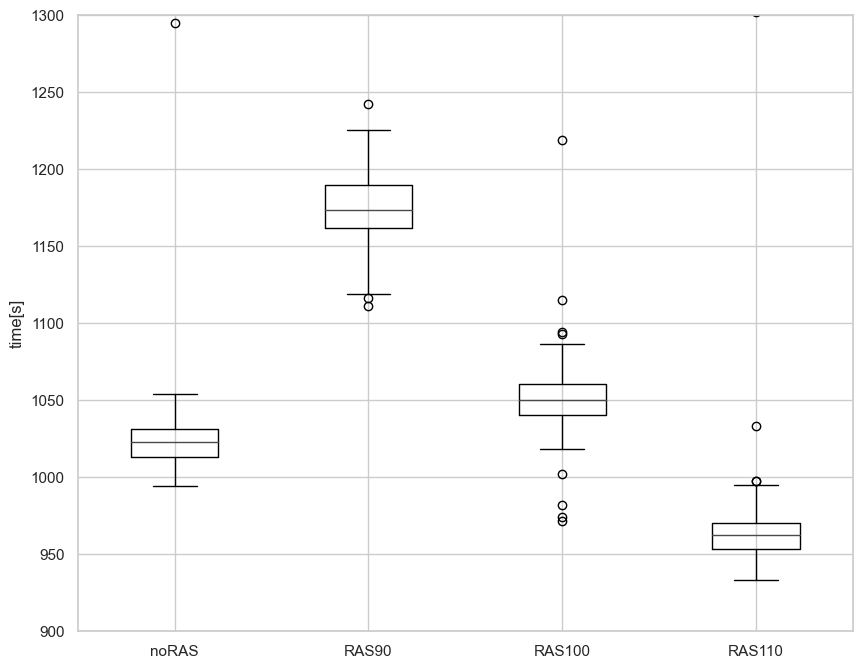

In [86]:
# sns.set()
# sns.set_style("whitegrid")
# sns.set_palette("Set3")

# df = pd.DataFrame({
#     "noRAS":big_res[0],
#     "RAS90":big_res[1],
#     "RAS100":big_res[2],
#     "RAS110":big_res[3]
# })
# df_melt = pd.melt(df)
# fig, ax = plt.subplots(figsize=(10,8))
# sns.boxplot(x="variable", y="value",data=df_melt, showfliers=False, ax=ax)
# sns.stripplot(x="variable",y="value",data=df_melt,jitter=True, color="black", ax=ax)

sns.set()
sns.set_style("whitegrid")
sns.set_palette("gray")

fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(big_res, labels=["noRAS","RAS90","RAS100","RAS110"])
ax.set_ylim(900,1300)
ax.set_ylabel("time[s]")


異常周期の除外、分散の何倍離れるか？



In [75]:
emg_epochs[0]

array([[0.17903597, 0.05178967, 0.0185556 , ..., 0.01106902, 0.01401351,
        0.00897178],
       [0.17902182, 0.0524439 , 0.0186517 , ..., 0.01112389, 0.01433266,
        0.0089711 ],
       [0.17893838, 0.05307244, 0.01876841, ..., 0.01117491, 0.01476879,
        0.00896548],
       ...,
       [0.19501476, 0.04979295, 0.03357713, ..., 0.02588964, 0.06991822,
        0.00752682],
       [0.19707771, 0.05033938, 0.03274445, ..., 0.02631022, 0.07036816,
        0.00762609],
       [0.19908626, 0.05087219, 0.03193795, ..., 0.0267374 , 0.07082731,
        0.00773   ]])

# コヒーレンスベースの解析

<AxesSubplot:>

<Figure size 640x480 with 0 Axes>

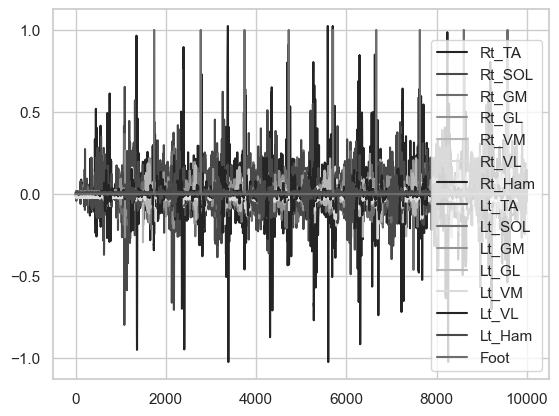

In [95]:
plt.clf()
fig, ax=plt.subplots()
emg.iloc[:10000,:].plot(ax=ax)

In [100]:
labels = ["Rt_TA", "Rt_SOL", "Rt_GL", "Rt_GM", "Rt_VM", "Rt_VL", "Rt_Ham", "Lt_TA", 
              "Lt_SOL", "Lt_GL", "Lt_GM", "Lt_VM", "Lt_VL", "Lt_Ham"]
h_freq = 5 / (1000/2)
l_freq = 250 / (1000/2)
Wn = 4
btype = "bandpass"
emg_list = []
event_list = []
epochs_list = []
RAS = ["noRAS","RAS90","RAS100","RAS110"]

emg = make_emg_obj(emg_path[3])  # file_path
emg = emg.iloc[:120000,:]
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)

emg_epochs = []
for ev in range(len(event_idx)):
    if ev+1 == len(event_idx):
        break
    else:
        emg_epochs.append(emg_prep.iloc[event_idx[ev]:event_idx[ev+1]])
emg_epoch = [i if i]
emg_list.append(emg_prep)
event_list.append(event_idx)
epochs_list.append(emg_epochs)

In [101]:
emg = make_emg_obj(emg_path[2])  # file_path
emg = emg.iloc[:120000,:]
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)

emg_epochs = []
for ev in range(len(event_idx)):
    if ev+1 == len(event_idx):
        break
    else:
        emg_epochs.append(emg_prep.iloc[event_idx[ev]:event_idx[ev+1]])
emg_list.append(emg_prep)
event_list.append(event_idx)
epochs_list.append(emg_epochs)
emg = make_emg_obj(emg_path[0])  # file_path
emg = emg.iloc[:120000,:]
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)

emg_epochs = []
for ev in range(len(event_idx)):
    if ev+1 == len(event_idx):
        break
    else:
        emg_epochs.append(emg_prep.iloc[event_idx[ev]:event_idx[ev+1]])
emg_list.append(emg_prep)
event_list.append(event_idx)
epochs_list.append(emg_epochs)
emg = make_emg_obj(emg_path[1])  # file_path
emg = emg.iloc[:120000,:]
emg_prep, event_idx = prep_emg(emg, h_freq, l_freq, Wn, btype)

emg_epochs = []
for ev in range(len(event_idx)):
    if ev+1 == len(event_idx):
        break
    else:
        emg_epochs.append(emg_prep.iloc[event_idx[ev]:event_idx[ev+1]])
emg_list.append(emg_prep)
event_list.append(event_idx)
epochs_list.append(emg_epochs)

In [138]:
nperseg = 256
res = np.zeros([int(nperseg/2)+1, 14,14])

coh_res = []
for emg_epochs in epochs_list:
    print(len(emg_epochs))
    for df in emg_epochs:
        resBig = np.ndarray((1,int(nperseg/2)+1,14,14))
        # print(len(df))
        # break
        for i,la1 in enumerate(df):
            for j,la2 in enumerate(df):
                res = np.zeros([int(nperseg/2)+1, 14,14])
                x = df[la1]
                y = df[la2]
                f, Cxy = signal.coherence(y, x, fs=1000, nperseg=nperseg)
                res[:,i,j] = Cxy
        resBig = np.append(resBig, res[np.newaxis],axis=0)
    coh_res.append(resBig)

In [125]:
a = 8<=f
b = f<13
alpha = a==b  # alpha
a = 13<=f
b = f < 26
beta = a==b  #beta
a = 26<=f
b = f < 30
gamma = a==b  #gamma
a = 0.5<=f
b = f < 4
delta = a==b  #delta
a = 4<=f
b = f < 8
theta = a==b  # theta

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [150]:
(epochs_list[0][0]).shape

(1054, 14)

Channels marked as bad:
none


In [145]:
resBig = np.append(resBig, res[np.newaxis],axis=0)

In [146]:
resBig.shape

(3, 129, 14, 14)

In [126]:
res.shape

(129, 14, 14)

In [128]:
#resBig[0]==resBig[1]

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

Text(0.5, 1.0, 'theta(4-8Hz)')

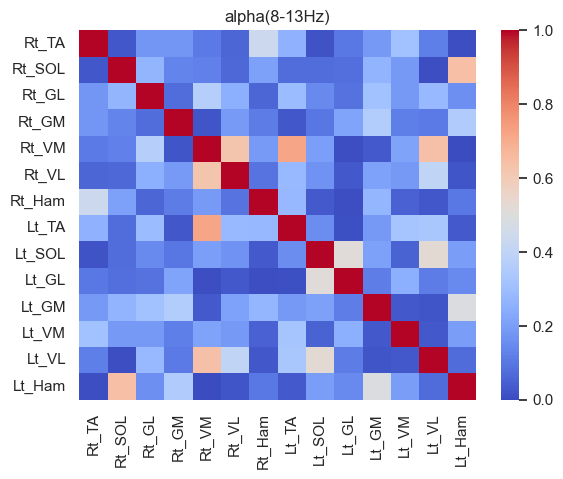

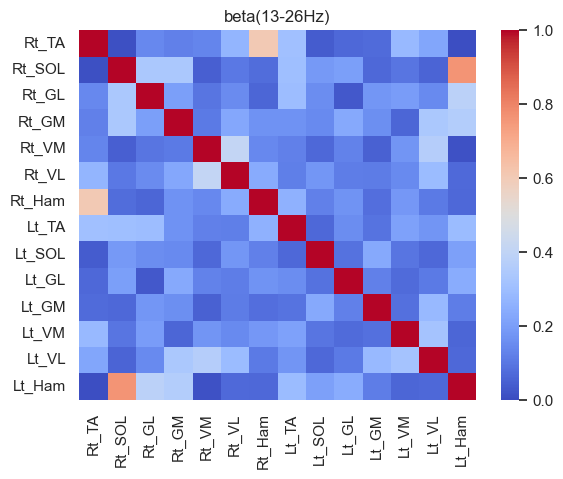

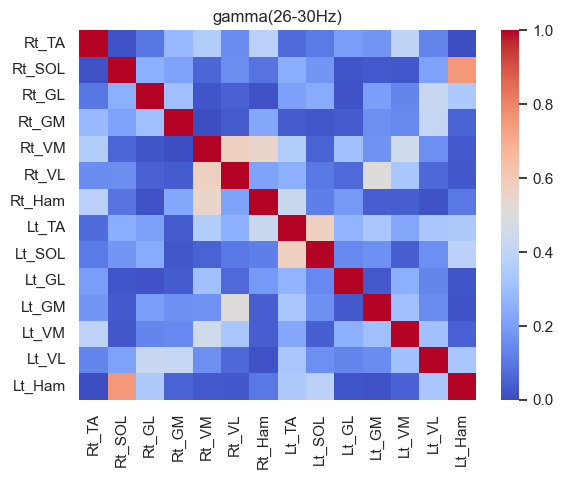

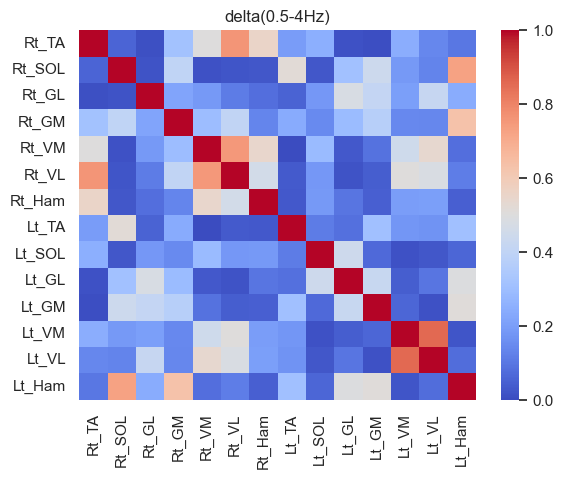

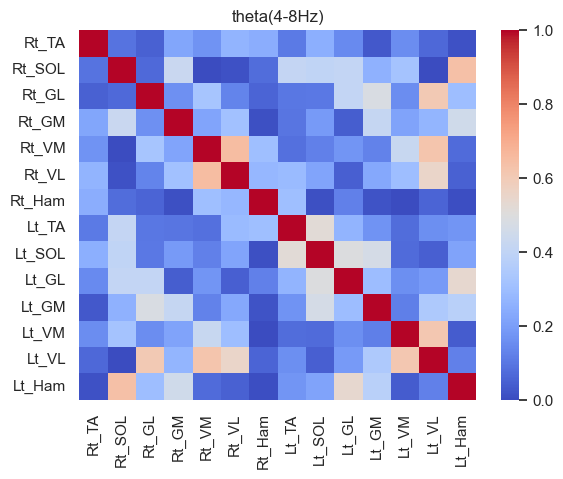

In [130]:
from matplotlib import animation, rc
from IPython.display import HTML
title = labels.copy()

fig,ax=plt.subplots()
coh_alpha = res[alpha,:,:].mean(axis=0)
coh_alpha = pd.DataFrame(coh_alpha, index=title, columns=title)
sns.heatmap(coh_alpha, cmap = "coolwarm", vmin=0,vmax=1.0)
plt.title("alpha(8-13Hz)")

fig,ax=plt.subplots()
coh_beta = res[beta,:,:].mean(axis=0)
coh_beta = pd.DataFrame(coh_beta, index=title, columns=title)
sns.heatmap(coh_beta, cmap = "coolwarm", vmin=0,vmax=1.0)
plt.title("beta(13-26Hz)")

fig,ax=plt.subplots()
coh_gamma = res[gamma,:,:].mean(axis=0)
coh_gamma = pd.DataFrame(coh_gamma, index=title, columns=title)
sns.heatmap(coh_gamma, cmap = "coolwarm", vmin=0,vmax=1.0)
plt.title("gamma(26-30Hz)")

fig,ax=plt.subplots()
coh_delta = res[delta,:,:].mean(axis=0)
coh_delta = pd.DataFrame(coh_delta, index=title, columns=title)
sns.heatmap(coh_delta, cmap = "coolwarm", vmin=0,vmax=1.0)
plt.title("delta(0.5-4Hz)")

fig,ax=plt.subplots()
coh_theta = res[theta,:,:].mean(axis=0)
coh_theta = pd.DataFrame(coh_theta, index=title, columns=title)
sns.heatmap(coh_theta, cmap = "coolwarm", vmin=0,vmax=1.0)
plt.title("theta(4-8Hz)")


In [140]:
resBig = coh_res[0]
resBig.shape

(2, 129, 14, 14)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

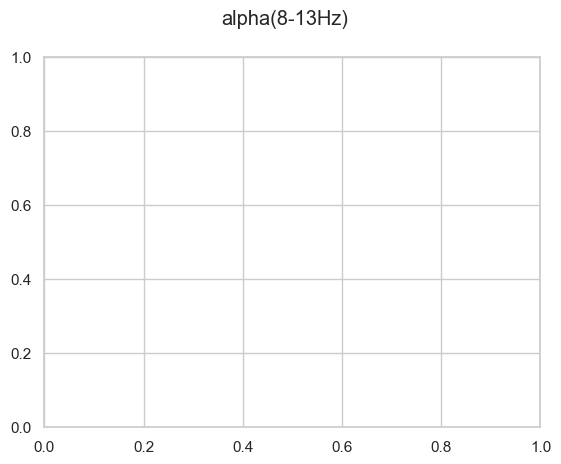

In [134]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ims = []
# fig = plt.figure()
fig,ax = plt.subplots()

plt.suptitle("alpha(8-13Hz)")
for i,res in enumerate(resBig):
    
    coh_alpha = res[alpha,:,:].mean(axis=0)
    coh_alpha = pd.DataFrame(coh_alpha, index=title, columns=title)
    # label = ax.set_title(f"alpha(8-13Hz):{i}epoch")
    label = ax.text(2,-1,f"alpha(8-13Hz):{i}epoch")
    im = ax.imshow(coh_alpha, cmap = "coolwarm", vmin=0,vmax=1.0)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    
    ims.append([im]+[label])

ani = animation.ArtistAnimation(fig, ims)
ani.save('alpha.mp4', writer="ffmpeg",dpi=100)
